In [1]:
from krylov import Krylov
from laf import LinearAssignmentFlow

import numpy as np
from skimage import img_as_float
from skimage.io import imread
import matplotlib.pyplot as plt

### Setup

In [2]:
img = img_as_float(imread('../images/Scales1.png'))

# ground truth labels
labels = np.asarray(
    [[0.203, 0.656, 0.324],  # darkgreen
    [0.891, 0.043, 0.0],  # red
    [0.258, 0.188, 0.953],  # dark blue
    [0.98, 0.848, 0.02],  # yellow
    [0.082, 0.973, 0.375],  # lightgreen
    [0.258, 0.52, 0.953],  # light blue
    [0.902, 0.227, 0.867],  # violet
    [0.914, 0.484, 0.141]]  # brown
)

# LAF
laf = LinearAssignmentFlow(img, labels)
A, b = laf()
x0 = np.zeros(b.shape)

### Parameters

In [3]:
distances = [1, 2, 4]
m_dims = [1, 2, 4, 8]

### Experiment

In [4]:
krylov_gt = Krylov(A, b, img.shape)
gt_results = krylov_gt(x0, 150, distances)
gt_results = np.stack(gt_results)


krylov = Krylov(A, b, img.shape)
all_results_uncorrected = []
all_results_corrected = []
for m in m_dims:
    results = krylov(x0, m, distances, err_correction=False, err_approx=3)
    all_results_uncorrected.append(results)
for m in m_dims:
    results = krylov(x0, m, distances, err_approx=3)
    all_results_corrected.append(results)

all_results = np.asarray([all_results_uncorrected, all_results_corrected])

error = np.linalg.norm(gt_results-all_results, axis=3).squeeze()

all_calls = krylov.calls
approx = [call['approx'] for call in all_calls]
approx = np.asarray([approx[:4], approx[4:]])  # [corr, m, dist, i_approx]

100%|██████████| 149/149 [00:29<00:00,  5.09it/s]
0it [00:00, ?it/s]
100%|██████████| 7/7 [00:01<00:00,  5.67it/s]
0it [00:00, ?it/s]
100%|██████████| 7/7 [00:00<00:00,  7.36it/s]


### Visualization

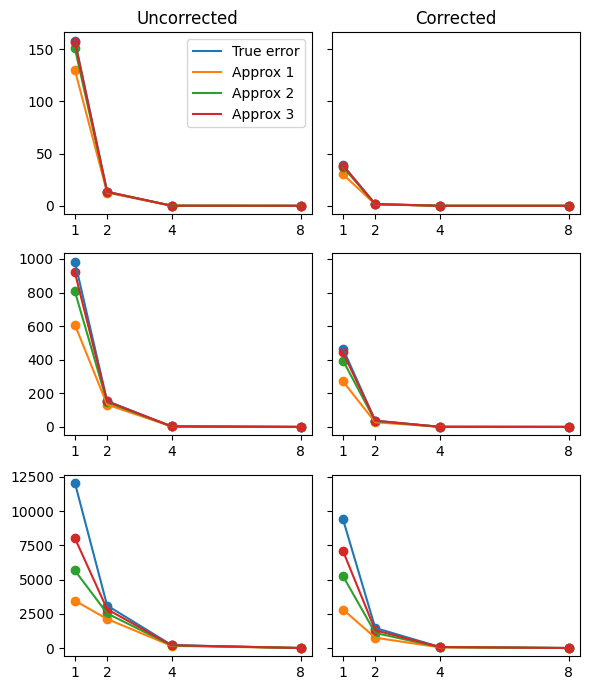

In [6]:
fig, ax = plt.subplots(3, 2, sharey='row', figsize=(6, 7))

for corr in [0, 1]:
    for d in range(len(distances)):
        ax[d, corr].plot(m_dims, error[corr, :, d], label='True error')
        ax[d, corr].scatter(m_dims, error[corr, :, d])
        for ap in range(3):
            ax[d, corr].plot(m_dims, approx[corr, :, d, ap], label=f'Approx {ap+1}')
            ax[d, corr].scatter(m_dims, approx[corr, :, d, ap])
        ax[d, corr].set_xticks(m_dims)
ax[0, 0].legend()
ax[0, 0].set_title('Uncorrected')
ax[0, 1].set_title('Corrected')
plt.tight_layout()
plt.show()